<a href="https://colab.research.google.com/github/akram1903/pneumonia_detection/blob/main/Fine_tuned_classifier_with_vgg16_and_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240520T111331Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44c24496d73d81cdc302e4f01483798d43c9e7d5766b10e41b42e8f033aee79ddd1d37a3fdd70c21450fd238c7fd79753c66df39ad210658ad1d15d92dcede626c16470c9380bff5ad987a239d5bc5916da76b28fffae4db58bab4e45ea6e9b76b77cde48493e6c680c5fafe6e45c089c8cea917ca8ff0eef4edb716cabf9a7366e730b6cf7ced292aa16d8387adff89566793919fdab3b43d926bfaebcfae721926b26f88578b8d906ae8611016473af0333030b2fc43d1e8c85335b5ea57b098f30087d1071d47c572a355177648919455919dd527d0abe813658eea1d912adf1b5c383b4af31cfb28841531629fcdc3281489f3c1f8cc0e7a9d6c07b1a20d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


This is a kernel to make classifier of 'NORMAL' or 'PNEUMONIA'.

I do transfer learning and finetuning. It's based on vgg16 model and replace output layer for 2 classes classifier.
I apply finetuning to its parameters.

I import PyTorch to do deep learning. Pretrained model is from PyTorch library.
Following script is not so complex, but the result is not bad.

I frequently insert simple comments. I hope this kernel is useful for PyTorch deep learning beginner.

In [ ]:
# import packages
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# Precondition : Accelerator GPU -> 'On'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device：", device)


using device： cuda:0


As the preprocess, I do random crop and color normalization for training data.

Chest X-ray images are taken from almost same angle. So preprocess is not so difficult.

One pneumonia example before and after preprocess is shown.

In 'PNEUMONIA' image, There is white area (seems pneumonia area), so it tends to be emphasized.
On the other hand, in 'NOMAL' image, ribs are clearly shown.

In [ ]:
# setting random number seed. Arbitrary seed is OK.
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# preprocess class for each image
class ImageTransform():

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                # data augmentation
                transforms.RandomResizedCrop(
                   resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                # convert to tensor for PyTorch
                transforms.ToTensor(),
                # color normalization
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):

        return self.data_transform[phase](img)



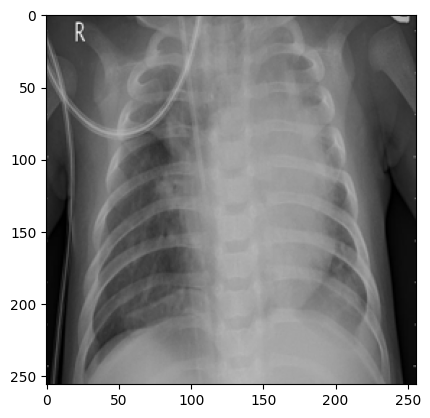

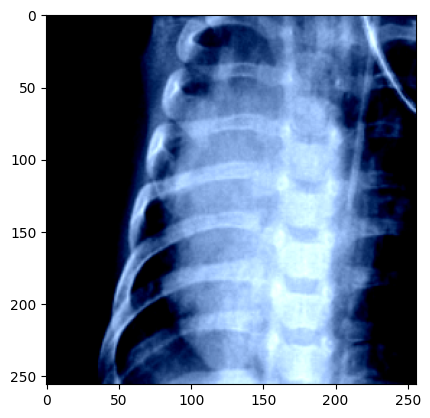

In [ ]:
# Showing one result of the preprocess

image_file_path = '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg'

img_originalsize = Image.open(image_file_path)   # [height][width][color RGB]
img = img_originalsize.resize((256, 256))

img = img.convert("L").convert("RGB")

# original image
plt.imshow(img)
plt.show()

# after preprocess
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (color, height, width) -> (height, width, color), normalize colors in the range (0 - 1)
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


For PyTorch dataloader, I prepare file path list and dataset.

Labels are made from file path. For PyTorch beginner, motion check raws are useful to debug.

In [ ]:
# making file path list
def make_datapath_list(phase="train"):

    rootpath = "../input/chest-xray-pneumonia/chest_xray/"

    target_path = osp.join(rootpath+phase+'/**/*.jpeg')
    print(target_path)

    path_list = []

    # getting file paths
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

../input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg
../input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg


In [ ]:
# making dataset

class lungDataset(data.Dataset):

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        # load image
        img_path = self.file_list[index]

        img_originalsize = Image.open(img_path)
        # resize
        img = img_originalsize.resize((256, 256))

        # grey -> color
        img = img.convert("L").convert("RGB")

        # preprocess
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # picking up labels
        if self.phase == "train":
            label = img_path[47:53]

        elif self.phase == "val":
            label = img_path[45:51]

        # label char -> number
        if label == "NORMAL":
            label = 0

        elif label == "PNEUMO":
            label = 1

        return img_transformed, label


# run
train_dataset = lungDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = lungDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# motion check
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

print(val_dataset.__getitem__(index)[0].size())
print(val_dataset.__getitem__(index)[1])


torch.Size([3, 256, 256])
1
torch.Size([3, 256, 256])
1


PyTorch dataloader needs dataset includinig label and data itself.

In the training phase, dataloader provide 'batch_size' data automatically.

In [ ]:
batch_size = 32

# making dataloader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# put dataloader into dictionary type
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# motion check
batch_iterator = iter(dataloaders_dict["train"])

inputs, labels = next(
    batch_iterator)  # pick up first element
print(inputs.size())
print(labels)


torch.Size([32, 3, 256, 256])
tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 0])


In [ ]:
# load pretrained vgg from PyTorch as an instance
# need to make setting 'internet' to 'On'.
use_pretrained = True
net = models.vgg19(pretrained=use_pretrained)

# Replace output layer for 2 class classifier, 'NORMAL' and 'PNEUMONIA'.
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# setting of loss function
criterion = nn.CrossEntropyLoss()

# setting fine tuned parameters

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# ====================================Tunning====================================
# update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# store parameters in list
for name, param in net.named_parameters():
#     if update_param_names_1[0] in name:
#         param.requires_grad = True
#         params_to_update_1.append(param)
#         #print("params_to_update_1:", name)

    if name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2:", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3:", name)

    else:
        param.requires_grad = False
        print("no learning", name)

# print("-----------")
# print(params_to_update_1)

# Learning Rates
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)


no learning features.0.weight
no learning features.0.bias
no learning features.2.weight
no learning features.2.bias
no learning features.5.weight
no learning features.5.bias
no learning features.7.weight
no learning features.7.bias
no learning features.10.weight
no learning features.10.bias
no learning features.12.weight
no learning features.12.bias
no learning features.14.weight
no learning features.14.bias
no learning features.16.weight
no learning features.16.bias
no learning features.19.weight
no learning features.19.bias
no learning features.21.weight
no learning features.21.bias
no learning features.23.weight
no learning features.23.bias
no learning features.25.weight
no learning features.25.bias
no learning features.28.weight
no learning features.28.bias
no learning features.30.weight
no learning features.30.bias
no learning features.32.weight
no learning features.32.bias
no learning features.34.weight
no learning features.34.bias
params_to_update_2: classifier.0.weight
params_t

In folowing training function, 'training_model', have accuracy_list and losslist.
They are for plot learing model in later phase.

In [ ]:
# training function
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    accuracy_list = []
    loss_list = []

    # Precondition : Accelerator GPU -> 'On'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using device：", device)

    # put betwork into GPU
    net.to(device)
    torch.backends.cudnn.benchmark = True

    # epoch loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # set network 'train' mode
            else:
                net.eval()   # set network 'val' mode

            epoch_loss = 0.0
            epoch_corrects = 0

            # Before training
            if (epoch == 0) and (phase == 'train'):
                continue


            # batch loop
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # send data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # initialize optimizer
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)

                    loss = criterion(outputs, labels)  #calcurate loss
                    _, preds = torch.max(outputs, 1)  # predict

                    # back propagtion
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # update loss summation
                    epoch_loss += loss.item() * inputs.size(0)
                    # update correct prediction summation
                    epoch_corrects += torch.sum(preds == labels.data)

            # loss and accuracy for each epoch loop
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val':
                accuracy_list.append(epoch_acc.item())
                loss_list.append(epoch_loss)

    return accuracy_list, loss_list


In [ ]:
# start training
num_epochs=5
accuracy_list, loss_list = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

using device： cuda:0
Epoch 1/5
-------------


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


val Loss: 0.6824 Acc: 0.5000
Epoch 2/5
-------------


100%|██████████| 163/163 [01:54<00:00,  1.42it/s]


train Loss: 0.2937 Acc: 0.8771


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


val Loss: 0.2589 Acc: 0.8750
Epoch 3/5
-------------


100%|██████████| 163/163 [01:54<00:00,  1.42it/s]


train Loss: 0.2102 Acc: 0.9193


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


val Loss: 0.3939 Acc: 0.7500
Epoch 4/5
-------------


100%|██████████| 163/163 [01:53<00:00,  1.43it/s]


train Loss: 0.2012 Acc: 0.9185


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


val Loss: 0.2258 Acc: 0.9375
Epoch 5/5
-------------


100%|██████████| 163/163 [01:54<00:00,  1.43it/s]


train Loss: 0.1793 Acc: 0.9247


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

val Loss: 0.3257 Acc: 0.7500


In [ ]:
# To save trained model
save_path = '/kaggle/working/weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)


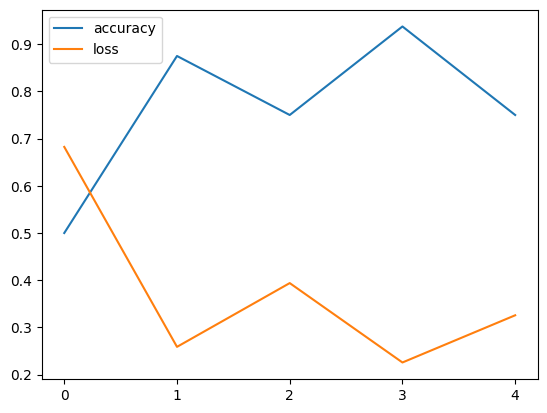

In [ ]:
epoch_num = list(range(num_epochs))
fig, ax = plt.subplots(facecolor="w")
ax.plot(epoch_num, accuracy_list, label="accuracy")
ax.plot(epoch_num, loss_list, label="loss")
plt.xticks(epoch_num)

ax.legend()

plt.show()

In [ ]:
def plot_image(test_sample, prediction, true_label):
  # true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(test_sample, cmap=plt.cm.binary)

  if prediction == true_label:
    color = 'blue'
    plt.xlabel("{}".format(prediction,
                                true_label),
                                color=color)

  else:
    color = 'red'
    plt.xlabel("{} Label: ({})".format(prediction,
                                    true_label),
                                    color=color)

  print(f'prediction: {prediction}, label: {true_label}')



In [ ]:

# input,output = dataloaders_dict["val"].dataset.__getitem__(0)
# # input
# input = input.to(device)
# # input
# # val_dataset[15][0].reshape()
# pred = net(input)

for inputs, labels in dataloaders_dict["val"]:
#     print("inputs = ",inputs)
    # send data to GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)  # predict
    break

preds
preds[1]
preds[1].dtype
# classes = ["normal","pneumonia"]

torch.int64

prediction: pneumonia, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: normal, label: pneumonia
prediction: normal, label: pneumonia
prediction: normal, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: pneumonia, label: pneumonia
prediction: normal, label: pneumonia
prediction: pneumonia, label: pneumonia


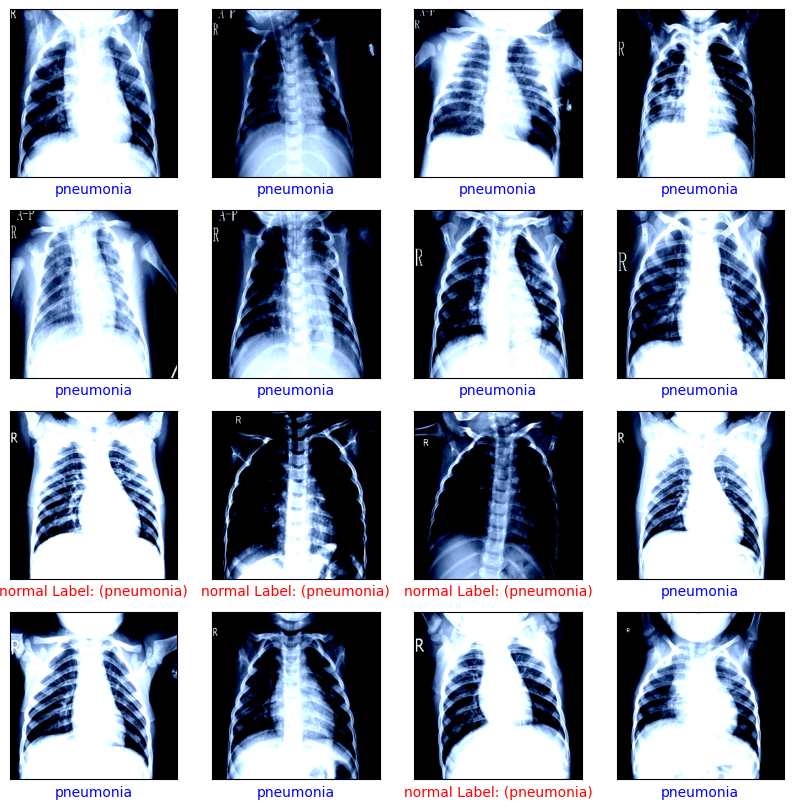

In [ ]:
import random
# randomIndices = random.choices(range(len(val_dataset)),k=16)

randomIndices = range(16)

plt.figure(figsize=(10,10))
index = 0
for i in randomIndices:
# test_data[0][0], test_data[0][1]
    plt.subplot(4,4,index+1)

    predicted, actual = classes[preds[i]], classes[y]
    plotable_img = torch.Tensor.cpu(inputs[i])
    plotable_img = plotable_img.permute(1, 2, 0)
    plot_image(plotable_img,predicted,actual)

    index += 1

plt.show()


In [ ]:
# load the model from file:
load_path = './weights_fine_tuning.pth'
net = net.to(device)
net.load_state_dict(torch.load(load_path))

<All keys matched successfully>